<a href="https://colab.research.google.com/github/drSever/drSever_data_science/blob/main/Learning_projects_dl/project_4/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача
Распознавание лиц — ключевая область в области компьютерного зрения и распознавания образов. Значительный объём исследований в прошлом способствовал созданию сложных алгоритмов распознавания лиц. С развитием свёрточных сетей стала возможна высокоточная классификация изображений. В прошлом модуле вы успешно распознали пятерых селебритис IT индустрии, обучив классификатор.     
Помимо разметки изображений часто встречаются задачи, когда важен определенный объект на изображении. Например, в связи с недавней вспышкой COVID19, ношение медицинских масок стало обязательным для всех, кто находится вне своего дома, что, в свою очередь привело к необходимости создания подхода для детектирования масок на лицах людей.

Представьте, что вашей компании выпала возможность помочь миру путем обучения модели для контроля ношения масок людьми. При этом вы хотите сравнить два типа изученных детекторов (одноуровневые и двухуровневые) и предоставить небольшой отчет своему руководству. Для того, чтобы обосновать коллегам выбор модели, вы решили использовать метрики Intersection over Union и Average Precision.

Данные для обучения находятся на платформе [Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

Набор данных состоит из 853 изображений.

Пример изображений:

<image src="https://lms-cdn.skillfactory.ru/assets/courseware/v1/57a64fafc1db095ca24dcf9f1d415b16/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/DSPRCV_Proj2_1_2.png.png" alt="Пример изображения" width="400">


Пример того, что хотим получить:

<image src="https://lms-cdn.skillfactory.ru/assets/courseware/v1/d224e27328c8342814ede7ad94f890b3/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/DSPRCV_Proj2_1_3.png.png" alt="Пример изображения" width="400">

# Решение

Для детектирования объектов на изображении используются 2 типа детекторов: одноступенчатые и двухступенчатые. Возьмем по одному детектору каждого типа, обучим на наших данных, получим метрики и сравним их. Из одноступенчатых будем использовать YOLO, из двухступенчатых - Faster RCNN.

При обучении модели Faster RCNN обнаружены ошибки, связанные c преобразованиями некоторых изображений (значения *x_max* выходят за диапазон [0,1] или *x_max < x_min*). При просмотре аннотаций ошибок не найдено. Поиск в интеренете приводит к выводу, что проблема связана с багами библиотеки Albumentations. Использованы разные методы обхода данного бага (например, если *x_max > 1*, то *x_max=1* и т.д.), но оптимальным решением принято удаление тех изображений из датасета, которые приводят к багам.

Надо также отметить, что наличие данных изображений в датасете не приводит к проблемам в работе YOLO.

## 1. Установим необходимые библиотеки и импортируем неоходимые модули:

In [1]:
!pip install -q kaggle
!pip install -q colorama

In [2]:
from google.colab import files

import numpy as np
import pandas as pd

import os
import glob
import xml.etree.ElementTree as et
from tqdm.notebook import tqdm, trange
import random
import colorama

import cv2
from PIL import Image, ImageDraw

import torch
import torchvision
from torchvision import transforms, datasets, models
from sklearn.metrics import auc
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

## 2. Загрузка данных с платформы Kaggle

Для загрузки данных с платформы Kaggle необходимо зайти в свой аккаунт на данной платформе и поучить Api Token (Your profile / Account / Create New Token) и сохранить его у себя на компьютере в виде файла .json

Теперь необходимо загрузить полученный токен (нажмите в ячейке вывода `"выбор файлов"`). Затем создадим новую скрытую папку `kaggle` (в домашней папке пользователя), скопируем туда полученный файл, установим разрешения на чтение/запись только для автора ноутбука:

In [3]:
# загружаем полученный токен
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleksandrdssf","key":"3e21d97c09d9f6bf346c3135102d7555"}'}

In [4]:
# создаем новую папку kaggle
!mkdir -p ~/.kaggle

# копируем в нее токен
!cp kaggle.json ~/.kaggle/

# устанавливаем права доступа на файл токена
!chmod 600 /root/.kaggle/kaggle.json

В разделе датасета, который хотим скачать, нажимаем `copy API command`, вставляем в кодовую ячейку ноутбука, не забыв поставить "!" перед коммандой:

In [5]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 396M/398M [00:11<00:00, 43.5MB/s]
100% 398M/398M [00:11<00:00, 35.6MB/s]


Создадим папку data, куда разархивируем полученный данные:

In [6]:
!mkdir data
!unzip -q face-mask-detection.zip -d data

## 3. Faster RCNN

### 3.1. Подготовка данных

Задаим путь к файлам изображений и аннотаций:

In [7]:
images_dir = './data/images/'
annotations_dir = './data/annotations/'

Зададим размер батча и число num_workers:

In [8]:
batch_size = 10
num_workers = 8

Удалим изображения, которые ведут к багам библиотеки Albumentations:

In [9]:
files_for_del = [
    'maksssksksss457',
    'maksssksksss706',
    'maksssksksss251',
    'maksssksksss501',
    'maksssksksss110',
    'maksssksksss616',
    'maksssksksss231',
    'maksssksksss93',
    'maksssksksss5',
    'maksssksksss787',
    'maksssksksss603'
]

for file in files_for_del:
    os.remove(f'{images_dir}/{file}.png')
    os.remove(f'{annotations_dir}/{file}.xml')

Загрузка данных в DataLoader:

In [10]:
class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width

        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]

        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0

        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]

        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)

            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)


            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes_corr = [xmin_corr, ymin_corr, xmax_corr, ymax_corr]

            boxes.append(boxes_corr)


        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  842 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[ 54.3256, 100.2400, 125.7674, 166.3200]]), 'labels': tensor([2]), 'area': tensor([4720.8789]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


Зададим функцию, которая выведет пример изображения и bbox из датасета:

In [11]:
def plot_img_bbox(img, target, ticks=True):
    """
    Функция принимает на вход изображение в виде тензора, таргет, значение параметра
    ticks (сетка с координатами) - по умолчанию True.
    Функция выводит изображение с bbox.
    """
    # задаем фигуру
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    # выводим изображение
    ax.imshow(img)
    # получаем все bbox связанные с данным изображением
    for box in (target['boxes']):
        # выполняем копию тензора в память cpu
        box = box.cpu()
        # получаем данные bbox, преобразуя их в координаты левого нижнего угла, ширину и высоту
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        ax.add_patch(rect)

    # если ticks=False, то убираем координаты
    if ticks is False:
        plt.xticks([])
        plt.yticks([])

    plt.show()

Зададим функцию, которая будет производить трансформации изображений датасета:

In [12]:
def get_transform(train):
    """
    Функция производит трансформацию изображений датасета, в зависимости от значения
    параметра train (True или False)
    """

    if train:
        return A.Compose([
                            #A.HorizontalFlip(0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            #A.augmentations.geometric.rotate.SafeRotate (limit=20,  p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

**Примечание:** в нашем конкретном случае дополнителные трансформации тренировочного датасета не приводят к улучшению метрик, а иногда ведут к появлению ошибок.

In [13]:
def collate_fn(batch):
    """ Функция для сборки батча """
    return tuple(zip(*batch))

Разделим нашу выборку на тренировочную и валидационную, а также создадим соответствующие даталоадеры:

In [14]:
# зададим параметры тренировочного и валидационного датасетов
dataset_train = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_valid = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и valid в соотношении 80/20

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[-tsize:])

# создадим тренировочный и валидационный загрузчики

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn
    )

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn
    )

print(f"Размер общего датасета = {len(dataset)}")
print(f"Размер train-датасета = {len(dataset_train)}")
print(f"Размер valid-датасета = {len(dataset_valid)}")

Размер общего датасета = 842
Размер train-датасета = 674
Размер valid-датасета = 168


Выведем случайную картинку с bbox нашего датасета:

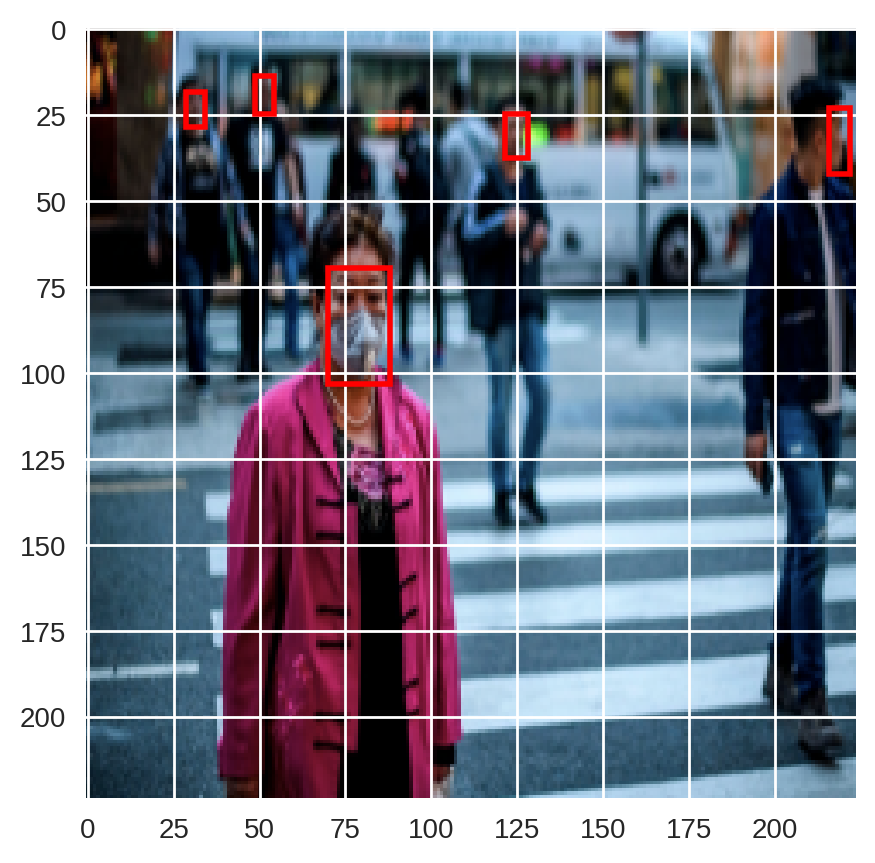

In [15]:
img, target = dataset[random.randint(1,len(dataset))]
plot_img_bbox(img, target)

### 3.2. Функции для обучения модели

Вдохновение черпалось из данных источников:
- [Семинар 6. Семантическая сегментация, детекция.](https://colab.research.google.com/github/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/sem_06.ipynb#scrollTo=5Pkva3QFDDed)
- [Intersection over Union (IoU) in Object Detection & Segmentation](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/)

Напишем функции необходимые для обучения модели:

In [16]:
def get_model_instance_segmentation(num_classes):
    """
    Функция загружает предобученную модель Faster RCNN и правит классификатор,
    с учетом необходимого количества классов, принятых на вход.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weigts=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Функция принимает на вход 2 массива с координатами bbox, где
    dt_bbox - предсказанные координаты
    gt_bbox - реальные координаты
    Функция возвращает IOU (Intersection Over Union)

    Intersection over Union между 2 bboxes
    (x0, y0) - координаты верхнего левого угла
    (x1, y1) - координаты нижнего правого угла

    :param dt_bbox: список или массив размерности (4,) [x0, y0, x1, y1]
    :param gt_bbox: список или массив размерности (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # координаты области пересечения
    ix1 = np.maximum(gt_bbox[0], dt_bbox[0])
    iy1 = np.maximum(gt_bbox[1], dt_bbox[1])
    ix2 = np.minimum(gt_bbox[2], dt_bbox[2])
    iy2 = np.minimum(gt_bbox[3], dt_bbox[3])

    # высота и ширина пересечения
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # размеры реального bbox
    gt_height = gt_bbox[3] - gt_bbox[1] + 1
    gt_width = gt_bbox[2] - gt_bbox[0] + 1

    # размеры предсказанного bbox
    pd_height = dt_bbox[3] - dt_bbox[1] + 1
    pd_width = dt_bbox[2] - dt_bbox[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

In [18]:
def evaluate_sample(target_pred: torch.Tensor, target_true, iou_threshold=0.5):
    """
    Функция получает предсказание и реальное значение сэмпла, рассчитывает пересечения
    предсказаных и реальных bbox с учетом порога IoU (=0.5 по умолчанию), возращает результат и
    IoU (общий).
    """
    # правильные прямоугольники
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # предсказания модели
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    # результаты пересечений bbox
    results = []
    # полученные IoU
    IoU_total = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5
            detection_result_dict["TP"] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)
        IoU_total.append(intersection_over_union(dt_bbox, gt_bbox))

    # возвращаем результат + IoU, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results, IoU_total

In [19]:
def evaluate(model, test_loader, device):
    """
    Функция принимает на вход модель, валидационный(тестовый) даталоадер, устройство;
    проходится по батчам, разбивая батч на сэмплы, и используя функцию evaluate_sample
    получает результаты по пересечению bbox и IoU по каждому сэмплу. Затем производит расчет
    метрик mAP, precision, recall и возращает их вместе с результатами IoU.
    """
    results = []
    IoU_total =[]
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # матчим ответы с правильными боксами, сохраняем IoU
                results.extend(evaluate_sample(target_pred, target_true)[0])
                IoU_total.extend(evaluate_sample(target_pred, target_true)[1])

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    # возвращаем mAP (как auc), precision, recall, IoU
    return auc(recall, precision), precision, recall, IoU_total

In [20]:
def train_one_epoch(model, optimizer, data_loader, device):
    """
    Функция принимает на вход модель, оптимайзер, даталоадер для обучения и устройство,
    проводит обучение модели на 1 эпохе, возвращая loss.
    """
    model.train()
    global_loss = 0
    for images, targets in tqdm(data_loader, leave=False, desc="Batch number"):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        global_loss += float(losses.cpu().detach().numpy())

    return global_loss


def train(model, train_loader, test_loader, optimizer, device, num_epochs=3):
    """
    Функция прнимает на вход модель, тренировочный и тестовый(валидационный) даталоадеры,
    оптимайзер, устройство и количество эпох обучения. На каждой эпохе происходит обучение
    на тренировочной выборке и валидация (используются функции train_one_epoch и evaluate),
    получая train_loss, а также mAP, precision, recall, IoU на валидации.
    Полученные метрики визуализируются в виде диаграмм.
    """
    # списки с результатами метрик на каждой эпохе
    mAP_plot = []
    precision_plot = []
    recall_plot = []
    IoU_mean_plot = []
    IoU_min_plot = []
    IoU_max_plot = []
    # список с количеством предсказанных bbox на каждой эпохе
    bbox_number_plot = []

    for epoch in trange(num_epochs, leave=True, desc=f"Epoch number"):
        loss_train = train_one_epoch(model, optimizer, train_loader, device)
        mAP, precision_total, recall_total, IoU_total = evaluate(model, test_loader, device=device)

        # получаем итоговые метрики
        precision = np.mean(precision_total)
        recall = np.mean(recall_total)
        IoU_mean = np.mean(IoU_total)
        IoU_min = np.min(IoU_total)
        IoU_max = np.max(IoU_total)

        # добавляем метрики текущей эпохи в списки
        precision_plot.append(precision)
        recall_plot.append(recall)
        IoU_mean_plot.append(IoU_mean)
        IoU_min_plot.append(IoU_min)
        IoU_max_plot.append(IoU_max)
        mAP_plot.append(mAP)
        bbox_number_plot.append(len(IoU_total))

        # выводим метрики
        print(f"\n** Epoch {epoch + 1} **")
        print("Train:")
        print(colorama.Fore.BLACK, f" loss_train after epoch {epoch + 1} is {loss_train:.2f}")
        print("Valid:")
        print(colorama.Fore.BLACK, f" mAP after epoch {epoch + 1} is {mAP:.2f}")
        print(colorama.Fore.RED, f" precision after epoch {epoch + 1} is {precision:.2f}")
        print(colorama.Fore.BLUE, f" recall after epoch {epoch + 1} is {recall:.2f}")
        print(colorama.Fore.GREEN, f" IoU_mean after epoch {epoch + 1} is {IoU_mean:.2f}")
        print(colorama.Fore.GREEN, f" IoU_min after epoch {epoch + 1} is {IoU_min:.2f}")
        print(colorama.Fore.GREEN, f" IoU_max after epoch {epoch + 1} is {IoU_max:.2f}")

    # визуализируем результаты
    plt.figure(figsize=(18, 4))

    plt.subplot(131)
    plt.plot(range(1, len(mAP_plot) + 1), mAP_plot, color="k")
    plt.plot(range(1, len(precision_plot) + 1), precision_plot, color="b")
    plt.plot(range(1, len(recall_plot) + 1), recall_plot, color="r")
    plt.xlabel("Номер эпохи")
    plt.legend(['mAP', 'Precision', 'Recall'], loc='best')
    plt.title("mAP, Precision и Recall на валидации")

    plt.subplot(132)
    plt.plot(range(1, len(IoU_mean_plot) + 1), IoU_mean_plot, color="k")
    plt.plot(range(1, len(IoU_min_plot) + 1), IoU_min_plot, color="m")
    plt.plot(range(1, len(IoU_max_plot) + 1), IoU_max_plot, color="c")
    plt.xlabel("Номер эпохи")
    plt.legend(['IoU_mean', 'IoU_min', 'IoU_max'], loc='best')
    plt.title("IoU на валидации")

    plt.subplot(133)
    plt.plot(range(1, len(bbox_number_plot) + 1), bbox_number_plot, color="k")
    plt.xlabel("Номер эпохи")
    plt.title("Кол-во предсказанных bbox на валидации")


    plt.show()

### 3.3. Обучение модели, получение метрик

In [21]:
# зададим устройство
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# определим количество классов
num_classes = 4

# определим модель для обучения, с учетом количества классов
model = get_model_instance_segmentation(num_classes)

# зададим количество эпох
num_epochs = 1

# зададим дополнительные параметры
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

# перенесем модель на наше устройство
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Обучаем модель:

Epoch number:   0%|          | 0/20 [00:00<?, ?it/s]

Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 1 **
Train:
  loss_train after epoch 1 is 50.50
Valid:
  mAP after epoch 1 is 0.19
  precision after epoch 1 is 0.11
  recall after epoch 1 is 0.55
  IoU_mean after epoch 1 is 0.10
  IoU_min after epoch 1 is 0.00
  IoU_max after epoch 1 is 0.89


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 2 **
Train:
  loss_train after epoch 2 is 37.61
Valid:
  mAP after epoch 2 is 0.58
  precision after epoch 2 is 0.29
  recall after epoch 2 is 0.68
  IoU_mean after epoch 2 is 0.13
  IoU_min after epoch 2 is 0.00
  IoU_max after epoch 2 is 0.95


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 3 **
Train:
  loss_train after epoch 3 is 33.13
Valid:
  mAP after epoch 3 is 0.74
  precision after epoch 3 is 0.40
  recall after epoch 3 is 0.74
  IoU_mean after epoch 3 is 0.13
  IoU_min after epoch 3 is 0.00
  IoU_max after epoch 3 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 4 **
Train:
  loss_train after epoch 4 is 27.90
Valid:
  mAP after epoch 4 is 0.80
  precision after epoch 4 is 0.47
  recall after epoch 4 is 0.77
  IoU_mean after epoch 4 is 0.14
  IoU_min after epoch 4 is 0.00
  IoU_max after epoch 4 is 0.96


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 5 **
Train:
  loss_train after epoch 5 is 25.20
Valid:
  mAP after epoch 5 is 0.83
  precision after epoch 5 is 0.45
  recall after epoch 5 is 0.80
  IoU_mean after epoch 5 is 0.13
  IoU_min after epoch 5 is 0.00
  IoU_max after epoch 5 is 0.95


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 6 **
Train:
  loss_train after epoch 6 is 24.09
Valid:
  mAP after epoch 6 is 0.82
  precision after epoch 6 is 0.64
  recall after epoch 6 is 0.72
  IoU_mean after epoch 6 is 0.16
  IoU_min after epoch 6 is 0.00
  IoU_max after epoch 6 is 0.98


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 7 **
Train:
  loss_train after epoch 7 is 21.57
Valid:
  mAP after epoch 7 is 0.85
  precision after epoch 7 is 0.60
  recall after epoch 7 is 0.76
  IoU_mean after epoch 7 is 0.14
  IoU_min after epoch 7 is 0.00
  IoU_max after epoch 7 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 8 **
Train:
  loss_train after epoch 8 is 20.35
Valid:
  mAP after epoch 8 is 0.85
  precision after epoch 8 is 0.68
  recall after epoch 8 is 0.73
  IoU_mean after epoch 8 is 0.16
  IoU_min after epoch 8 is 0.00
  IoU_max after epoch 8 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 9 **
Train:
  loss_train after epoch 9 is 18.47
Valid:
  mAP after epoch 9 is 0.84
  precision after epoch 9 is 0.61
  recall after epoch 9 is 0.75
  IoU_mean after epoch 9 is 0.13
  IoU_min after epoch 9 is 0.00
  IoU_max after epoch 9 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 10 **
Train:
  loss_train after epoch 10 is 17.56
Valid:
  mAP after epoch 10 is 0.87
  precision after epoch 10 is 0.72
  recall after epoch 10 is 0.72
  IoU_mean after epoch 10 is 0.17
  IoU_min after epoch 10 is 0.00
  IoU_max after epoch 10 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 11 **
Train:
  loss_train after epoch 11 is 16.93
Valid:
  mAP after epoch 11 is 0.86
  precision after epoch 11 is 0.75
  recall after epoch 11 is 0.70
  IoU_mean after epoch 11 is 0.17
  IoU_min after epoch 11 is 0.00
  IoU_max after epoch 11 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 12 **
Train:
  loss_train after epoch 12 is 16.06
Valid:
  mAP after epoch 12 is 0.86
  precision after epoch 12 is 0.73
  recall after epoch 12 is 0.71
  IoU_mean after epoch 12 is 0.18
  IoU_min after epoch 12 is 0.00
  IoU_max after epoch 12 is 0.98


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 13 **
Train:
  loss_train after epoch 13 is 15.39
Valid:
  mAP after epoch 13 is 0.86
  precision after epoch 13 is 0.75
  recall after epoch 13 is 0.70
  IoU_mean after epoch 13 is 0.18
  IoU_min after epoch 13 is 0.00
  IoU_max after epoch 13 is 0.98


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 14 **
Train:
  loss_train after epoch 14 is 14.33
Valid:
  mAP after epoch 14 is 0.87
  precision after epoch 14 is 0.81
  recall after epoch 14 is 0.67
  IoU_mean after epoch 14 is 0.19
  IoU_min after epoch 14 is 0.00
  IoU_max after epoch 14 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 15 **
Train:
  loss_train after epoch 15 is 13.38
Valid:
  mAP after epoch 15 is 0.87
  precision after epoch 15 is 0.72
  recall after epoch 15 is 0.72
  IoU_mean after epoch 15 is 0.17
  IoU_min after epoch 15 is 0.00
  IoU_max after epoch 15 is 0.98


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 16 **
Train:
  loss_train after epoch 16 is 13.04
Valid:
  mAP after epoch 16 is 0.83
  precision after epoch 16 is 0.77
  recall after epoch 16 is 0.67
  IoU_mean after epoch 16 is 0.18
  IoU_min after epoch 16 is 0.00
  IoU_max after epoch 16 is 0.96


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 17 **
Train:
  loss_train after epoch 17 is 13.06
Valid:
  mAP after epoch 17 is 0.87
  precision after epoch 17 is 0.81
  recall after epoch 17 is 0.67
  IoU_mean after epoch 17 is 0.19
  IoU_min after epoch 17 is 0.00
  IoU_max after epoch 17 is 0.97


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 18 **
Train:
  loss_train after epoch 18 is 11.92
Valid:
  mAP after epoch 18 is 0.87
  precision after epoch 18 is 0.76
  recall after epoch 18 is 0.70
  IoU_mean after epoch 18 is 0.17
  IoU_min after epoch 18 is 0.00
  IoU_max after epoch 18 is 0.99


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 19 **
Train:
  loss_train after epoch 19 is 12.09
Valid:
  mAP after epoch 19 is 0.86
  precision after epoch 19 is 0.86
  recall after epoch 19 is 0.63
  IoU_mean after epoch 19 is 0.21
  IoU_min after epoch 19 is 0.00
  IoU_max after epoch 19 is 0.98


Batch number:   0%|          | 0/68 [00:00<?, ?it/s]


** Epoch 20 **
Train:
  loss_train after epoch 20 is 11.46
Valid:
  mAP after epoch 20 is 0.88
  precision after epoch 20 is 0.83
  recall after epoch 20 is 0.67
  IoU_mean after epoch 20 is 0.18
  IoU_min after epoch 20 is 0.00
  IoU_max after epoch 20 is 0.97


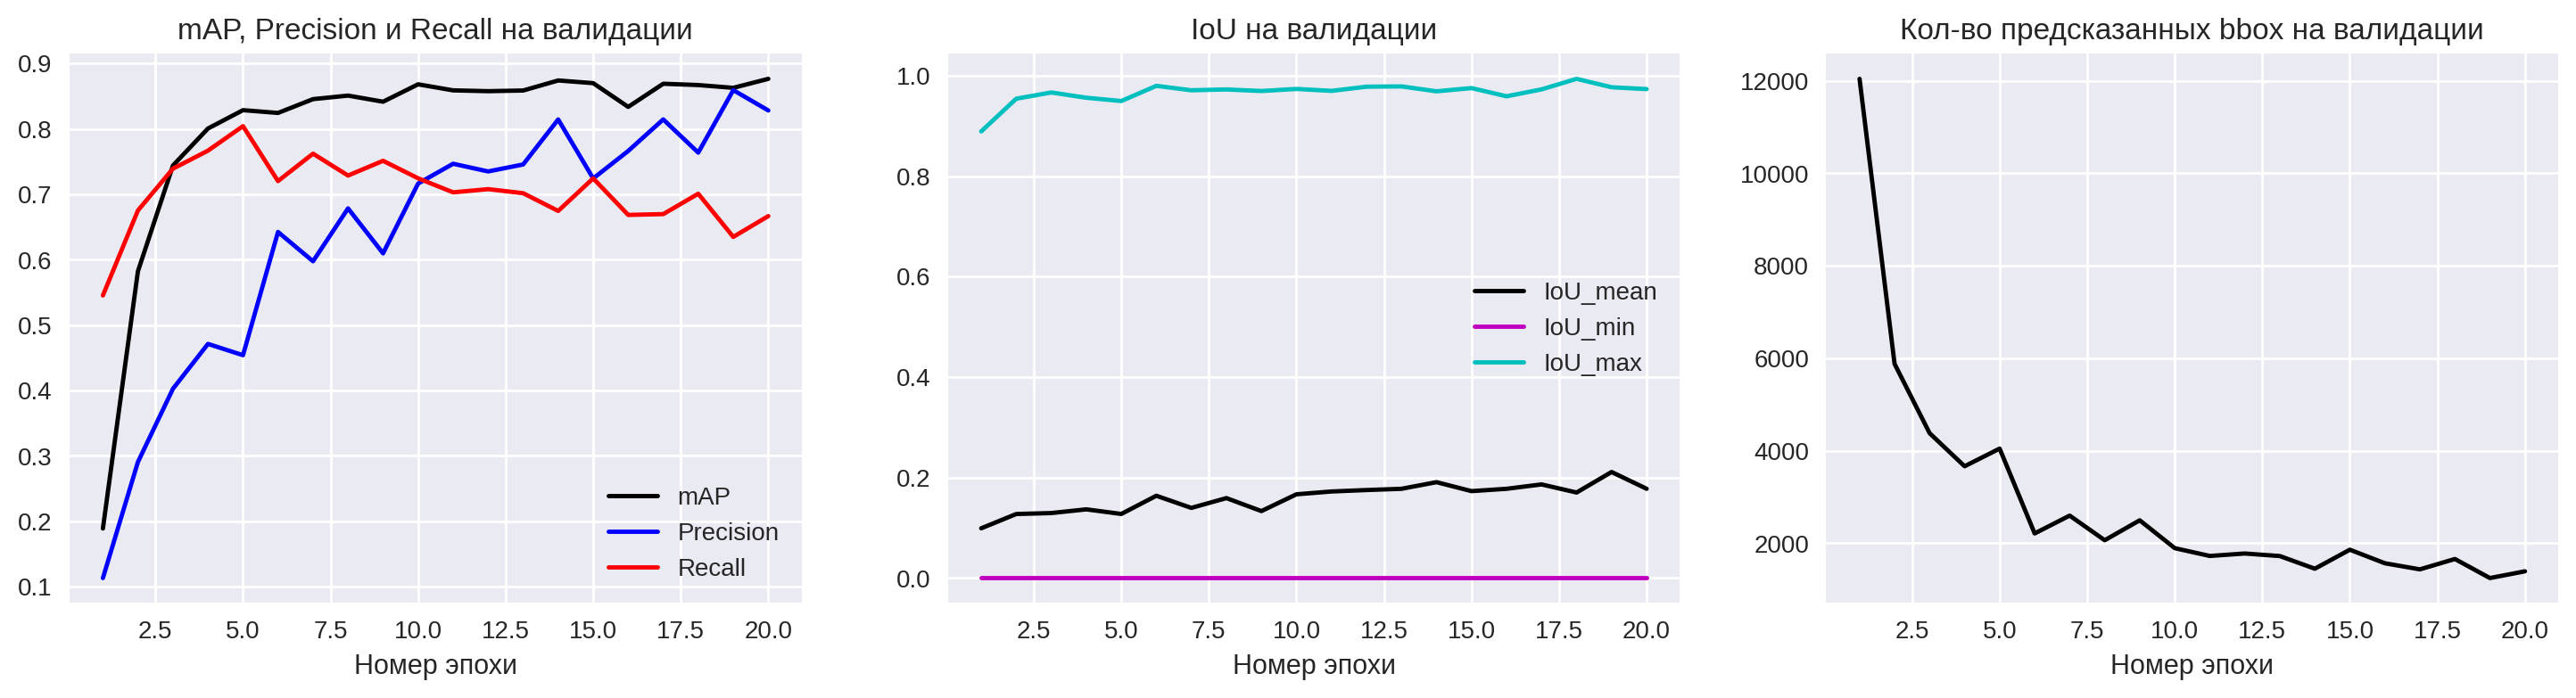

In [22]:
train(model, data_loader_train, data_loader_valid, optimizer, device, num_epochs=20)

### 3.4. Визуализируем полученные результаты

Зададим необходимые функции:

In [23]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    """
    Функция принимает на вход исходный прогноз модели и порог IoU,
    возвращает окончательный прогноз, отфильтрованный по порогу IoU
    """

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    """ Функция преобразует тензор в изображение """
    return transforms.ToPILImage()(img).convert('RGB')

Возьмем случайное изображение из валидационного датасета:

In [33]:
img, target = dataset_valid[random.randint(1,len(dataset_valid))]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('Количество предсказанных bbox на изображении: ', len(prediction['labels']))
print('Реальное количество bbox на изображении: ', len(target['labels']))

Количество предсказанных bbox на изображении:  23
Реальное количество bbox на изображении:  11


Выведем дополнительно это изображение с реальными и предсказанными bbox:

РЕАЛЬНЫЙ РЕЗУЛЬТАТ


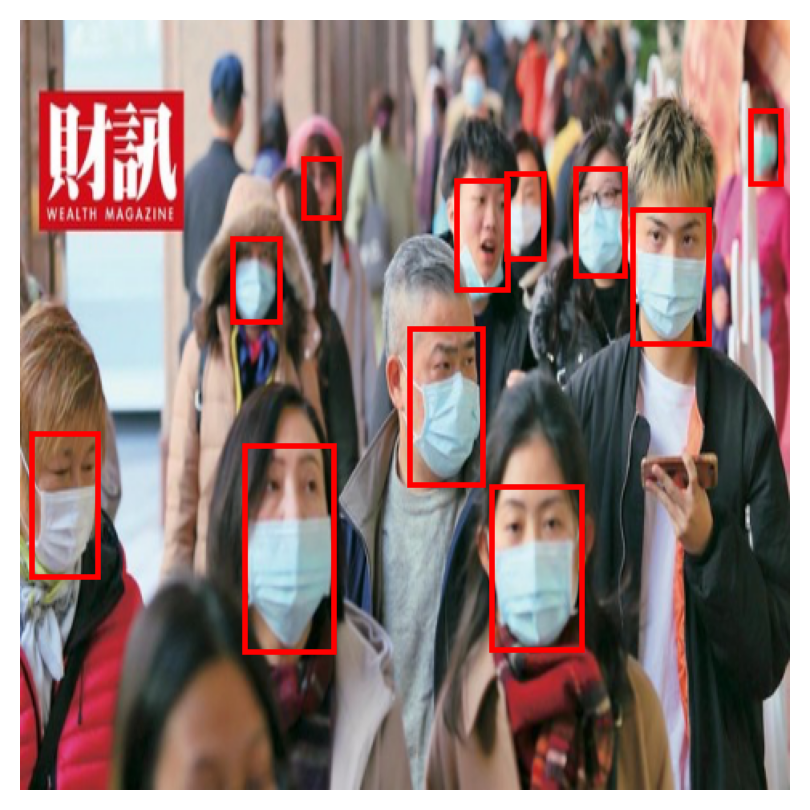

ПРЕДСКАЗАНИЕ МОДЕЛИ


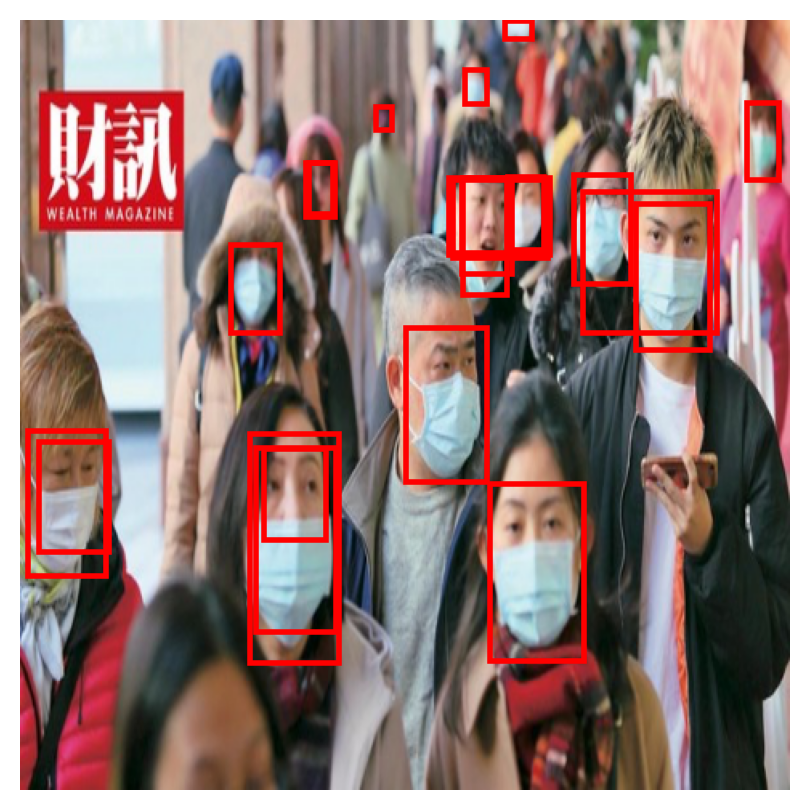

In [34]:
print('РЕАЛЬНЫЙ РЕЗУЛЬТАТ')
plot_img_bbox(torch_to_pil(img), target, ticks=False)
print('ПРЕДСКАЗАНИЕ МОДЕЛИ')
plot_img_bbox(torch_to_pil(img), prediction, ticks=False)

Повторно выведем предсказание модели, но отфильтруем по уровню IoU:

NMS ПРЕДСКАЗАНИЕ МОДЕЛИ


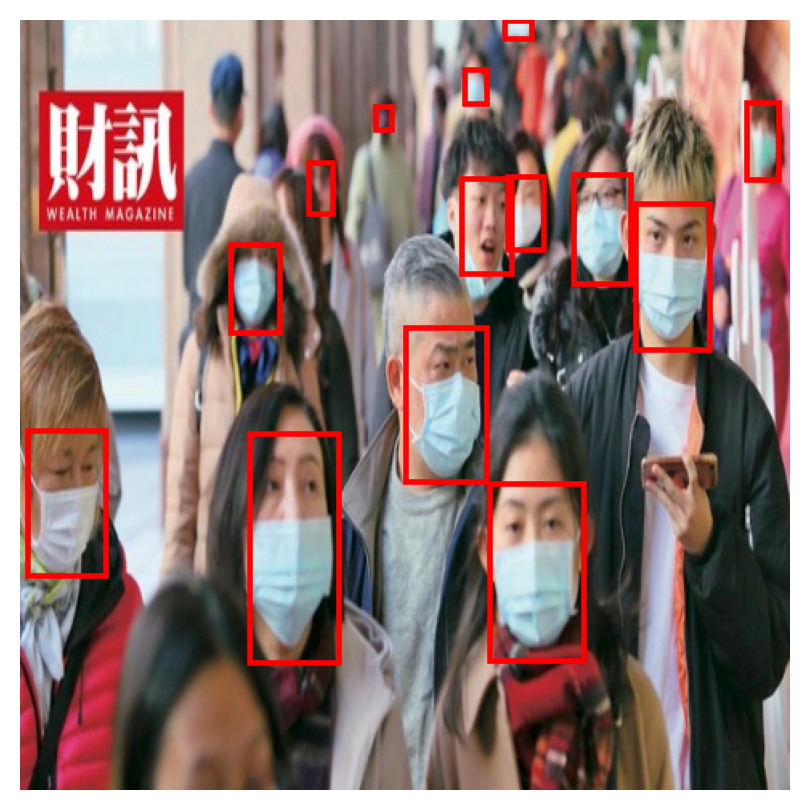

In [35]:
nms_prediction = apply_nms(prediction, iou_thresh=0.1)
print('NMS ПРЕДСКАЗАНИЕ МОДЕЛИ')
plot_img_bbox(torch_to_pil(img), nms_prediction, ticks=False)

Теперь возьмем даталоадер для валидации, извлечем изображение с реальными bbox и метками и получим предсказание модели с bbox и с вероятностями классов:

In [27]:
def plot_image(img_tensor, annotation, predict=True):
    """
    Функция принимает на вход изображение (тензор), реальный или предсказанный таргет,
    значение predict (для предсказанного таргета значение должно быть True).
    Возвращает изображение с bbox и метками классов (для предсказанного таргета с вероятностями).
    """

    # словарь с метками классов
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_weared_incorrect'}

    # перемещаем в память процессора
    img = img_tensor.cpu().data
    annotation["boxes"] = annotation["boxes"].cpu().data
    annotation['labels'] = annotation['labels'].cpu().data

    # Визуализация
    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)

    ax.imshow(img.permute(1, 2, 0))

    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        # Формируем рамку
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # добавляем рамку и метку класса
        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            # + вероятности
            annotation['scores'] = annotation['scores'].cpu().data
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
    plt.show()

Получим первый батч из валидационного даталоадера:

In [28]:
for imgs, annotations in data_loader_valid:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

Выполним предсказание на обученной модели:

In [29]:
model.eval()
preds = model(imgs)

Возьмем, в данном случае, 5-й сэмпл из батча: само изображение, реальные bbox и метки классов (отрисуем на первом изображении) и предсказанные bbox, метки классов и их вероятности (+ фильтр по уровню IoU) и отрисуем их на втором изображении:

Prediction


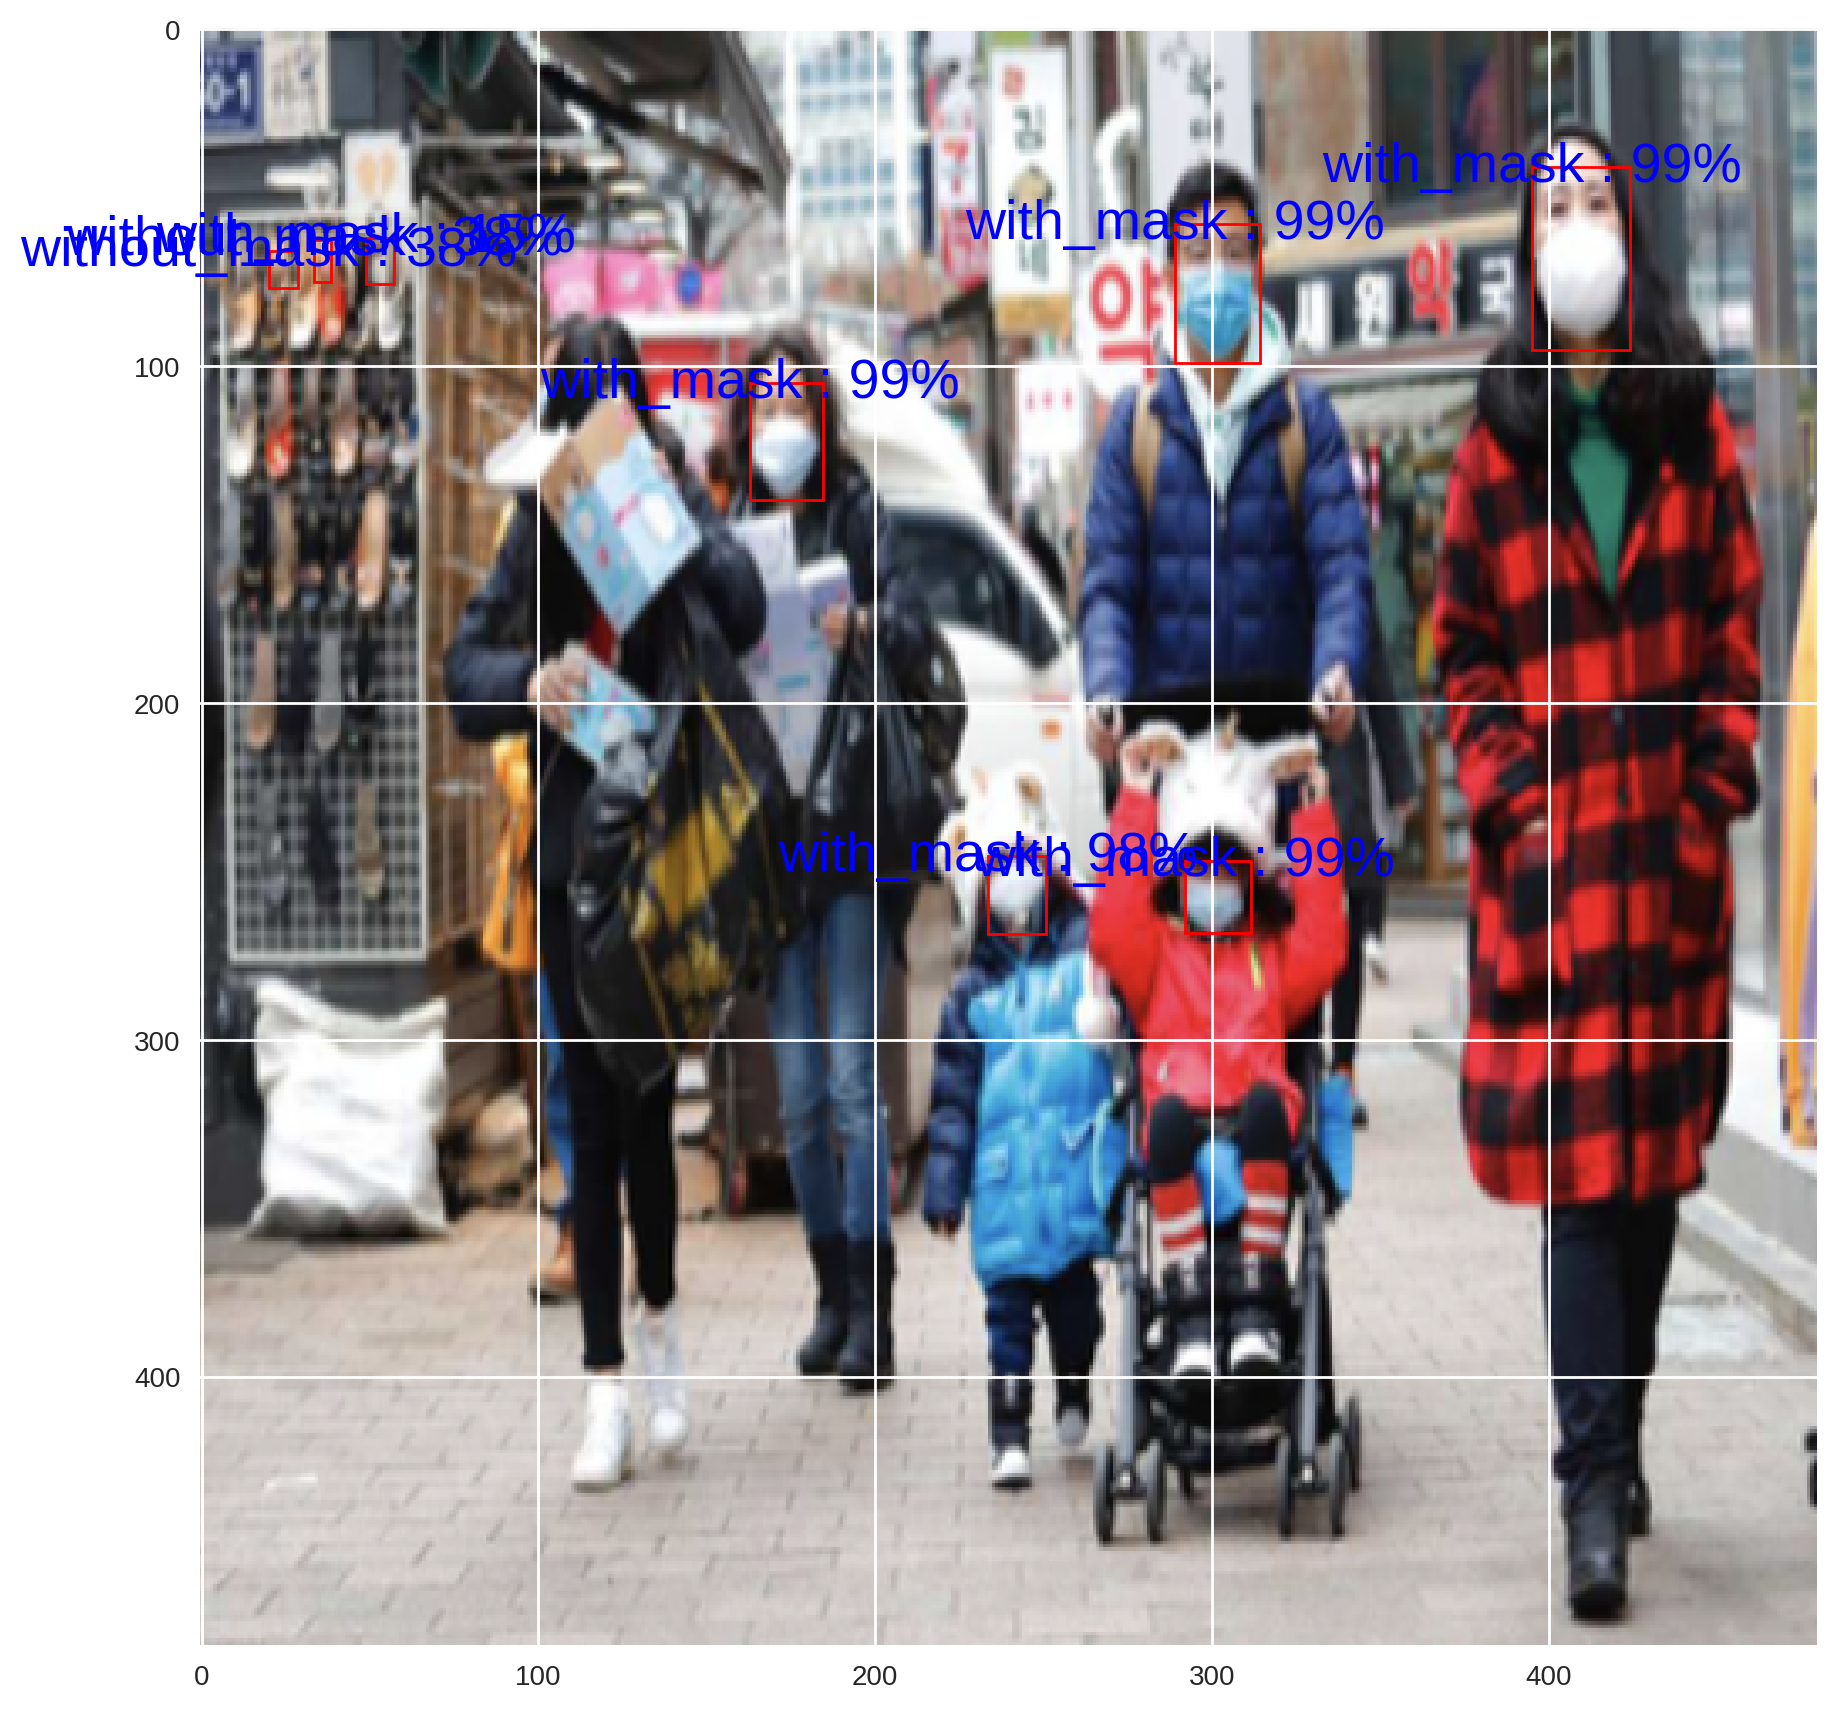

Target


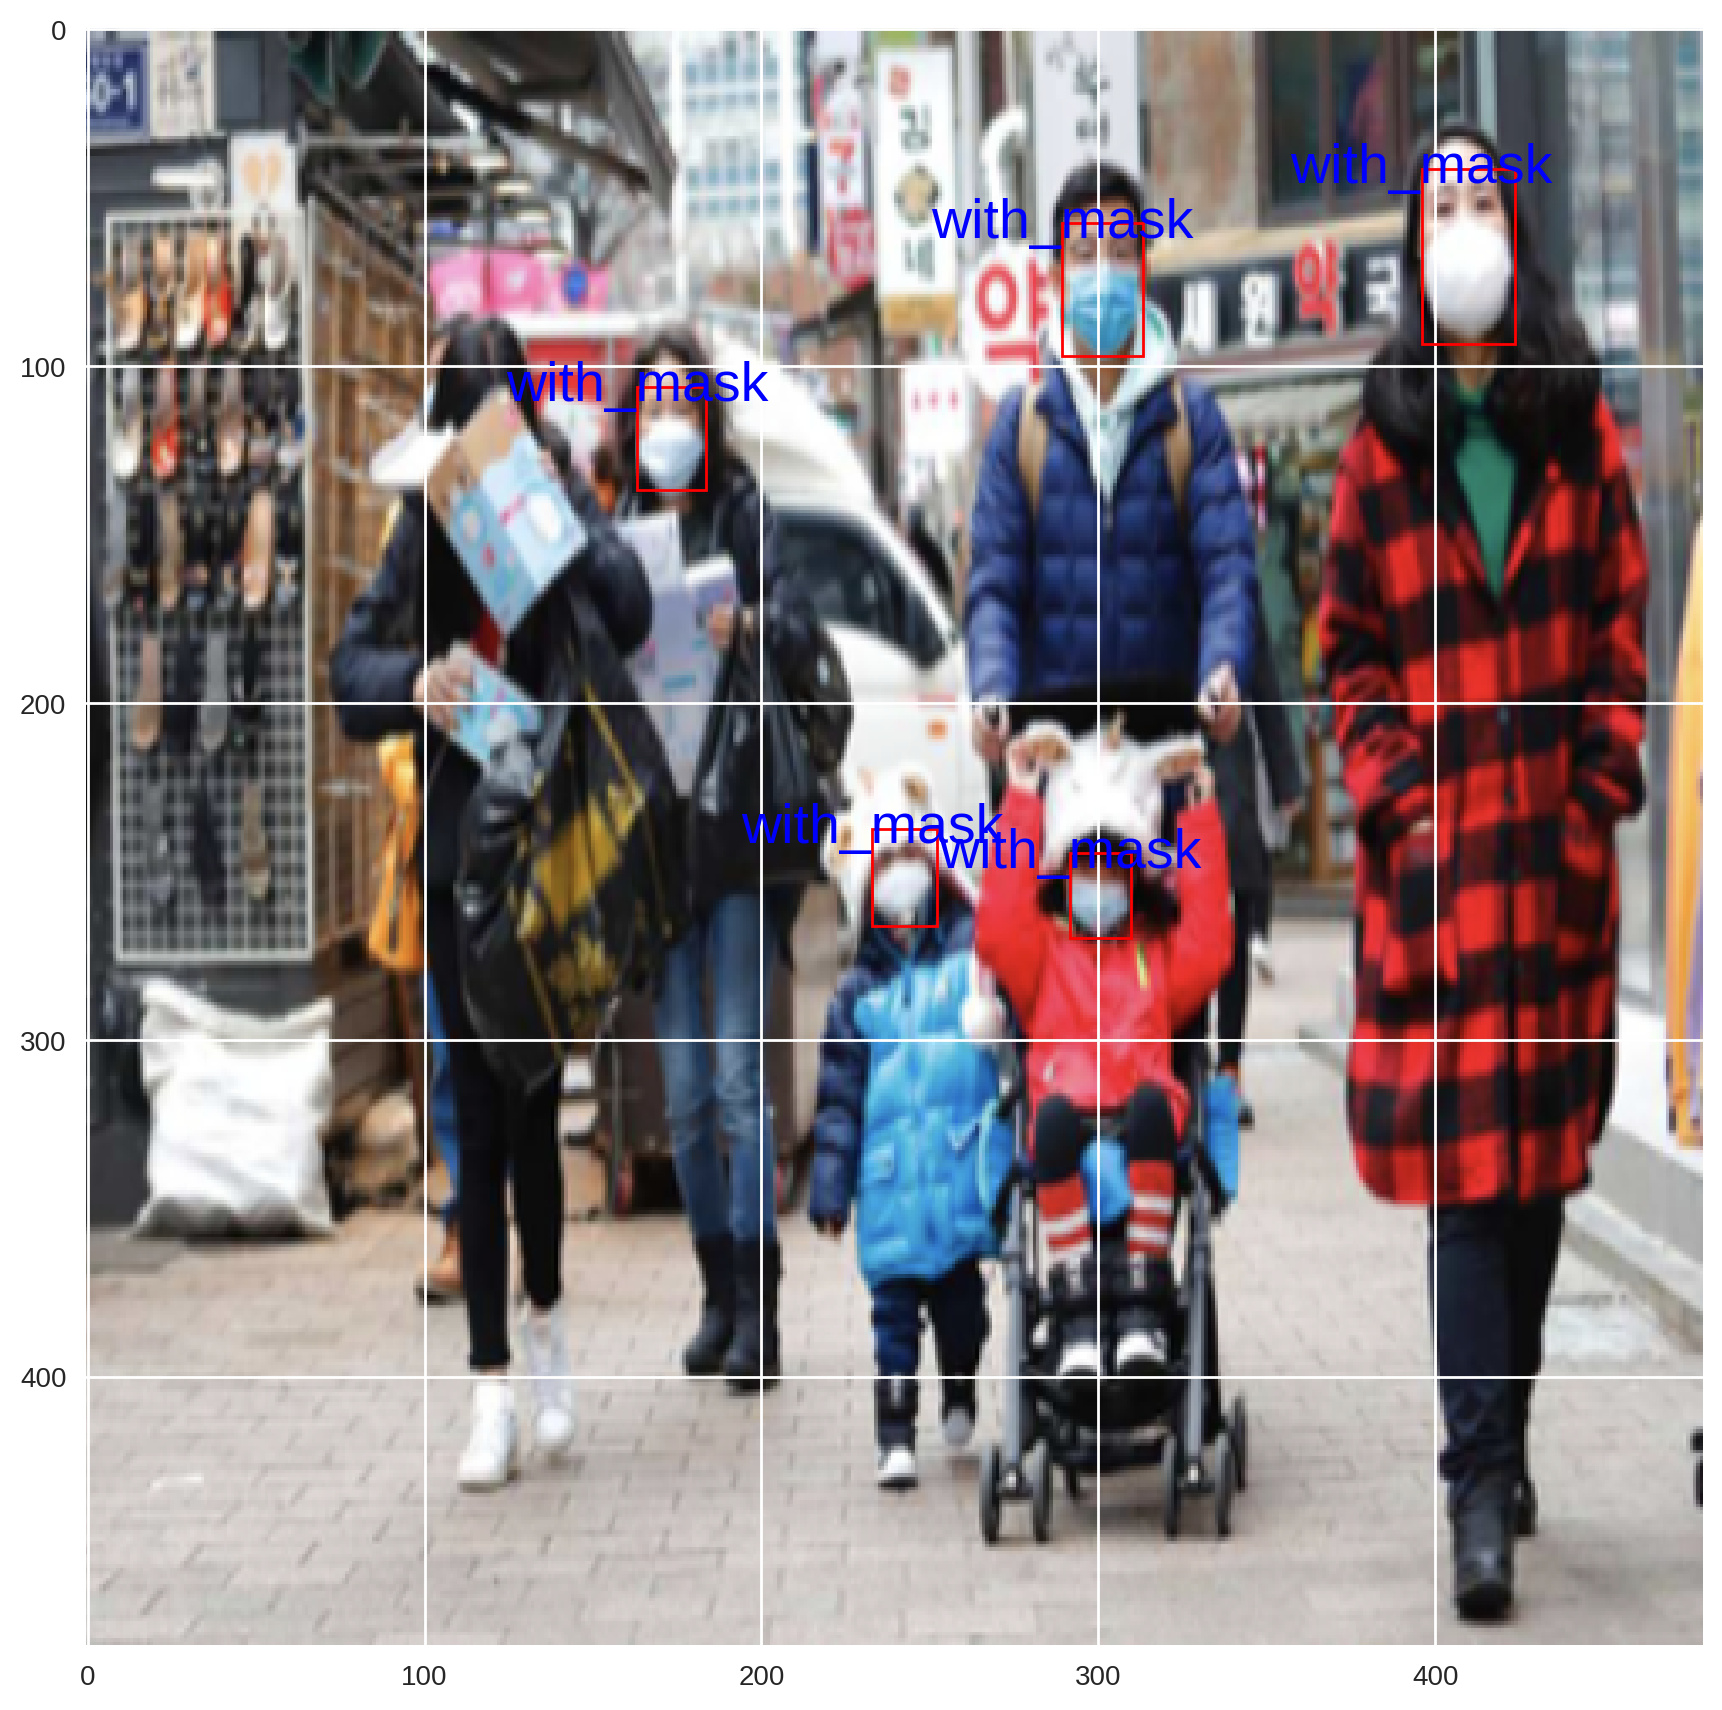

In [30]:
nms_prediction = apply_nms(preds[4], iou_thresh=0.1)
print("Prediction")
plot_image(imgs[4], nms_prediction)

print("Target")
plot_image(imgs[4], annotations[4], predict=False)

**Выводы:**
- мы получили значение mAP (в данном случае mAP_50) >0.85, выполнив задачу
- обнаружено, что модель склонна предсказывать количество bbox значительно больше их реального количества, хотя эта склонность снижается с увеличением количества эпох обучения
- но в то же время, с самых первых эпох мы видим предсказаные bbox IoU которых > 0.9
- использование фильтра по уровню IoU позволяет улучшить результаты предсказаний
- модель достаточно ресурсоемка и требует большого времени для дообучения

## 4. YOLO

### 4.1. Установим и импортируем дополнительные модули и библиотеки

In [36]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 10.5 MB/s eta 0:00:00


In [37]:
from ultralytics import YOLO

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from IPython.display import display, Image

import shutil

### 4.2. Подготовим данные

Очень помогла эта статья - [How to Train YOLO v5 on a Custom Dataset](https://blog.paperspace.com/train-yolov5-custom-data/).

Наша главная проблема на текущий момент - формат датасета не совпадает с форматом YOLO. Приведем наши данные к формату YOLO.

In [38]:
def extract_info_from_xml(xml_file):
    """
    Функция извлекает аннотации к изображению из файла .xml
    и возвращает список словарей, где каждый словарь - это объект на изображении
    и содержит метку класса и координаты рамок.
    """
    root = et.parse(xml_file).getroot()

    # инициализируем словари с нужными данными
    info_dict = {}
    info_dict['bboxes'] = []

    # парсинг .xml файлов
    for elem in root:
        # получаем имя файла
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # получаем размер изображения
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # получаем данные bbox (класс и рамки)
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

Проверим на файле `.xml`, что данные извлекаются правильно:

In [39]:
print(extract_info_from_xml('/content/data/annotations/maksssksksss0.xml'))

{'bboxes': [{'class': 'without_mask', 'xmin': 79, 'ymin': 105, 'xmax': 109, 'ymax': 142}, {'class': 'with_mask', 'xmin': 185, 'ymin': 100, 'xmax': 226, 'ymax': 144}, {'class': 'without_mask', 'xmin': 325, 'ymin': 90, 'xmax': 360, 'ymax': 141}], 'filename': 'maksssksksss0.png', 'image_size': (512, 366, 3)}


In [40]:
# зададим словарь с названиями и метками классов
class_name_to_id_mapping = {"mask_weared_incorrect": 0,
                           "with_mask": 1,
                           "without_mask": 2}

In [41]:
def convert_to_yolov5(info_dict):
    """
    Функция конвертирет извлекаемую информацию в виде словаря из .xml файла и
    преобразует ее в формат YOLO, сохраняя его в файл .txt.
    """
    print_buffer = []

    # проходим по всем bbox, получая класс
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # переводим координаты bbox в формат YOLO
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # нормализация
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        # сохраняем информацию bbox
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # имя файла для сохранения
    save_file_name = os.path.join("/content/data/annotations", info_dict["filename"].replace("png", "txt"))

    # сохраняем аннотацию в формате YOLO на диск в виде .txt
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [42]:
# получаем аннотации
annotations = [os.path.join('/content/data/annotations', x) for x in os.listdir('/content/data/annotations') if x[-3:] == "xml"]
annotations.sort()

# конвертируем и сохраняем новые аннотации в формате YOLO
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/data/annotations', x) for x in os.listdir('/content/data/annotations') if x[-3:] == "txt"]

  0%|          | 0/842 [00:00<?, ?it/s]

In [43]:
def plot_bounding_box(image, annotation_list):
    """
    Функция принимает изображение, аннотации в формате YOLO и
    выводит изображение с bbox.
    """
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        # выводим рамки
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        # выводим класс
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

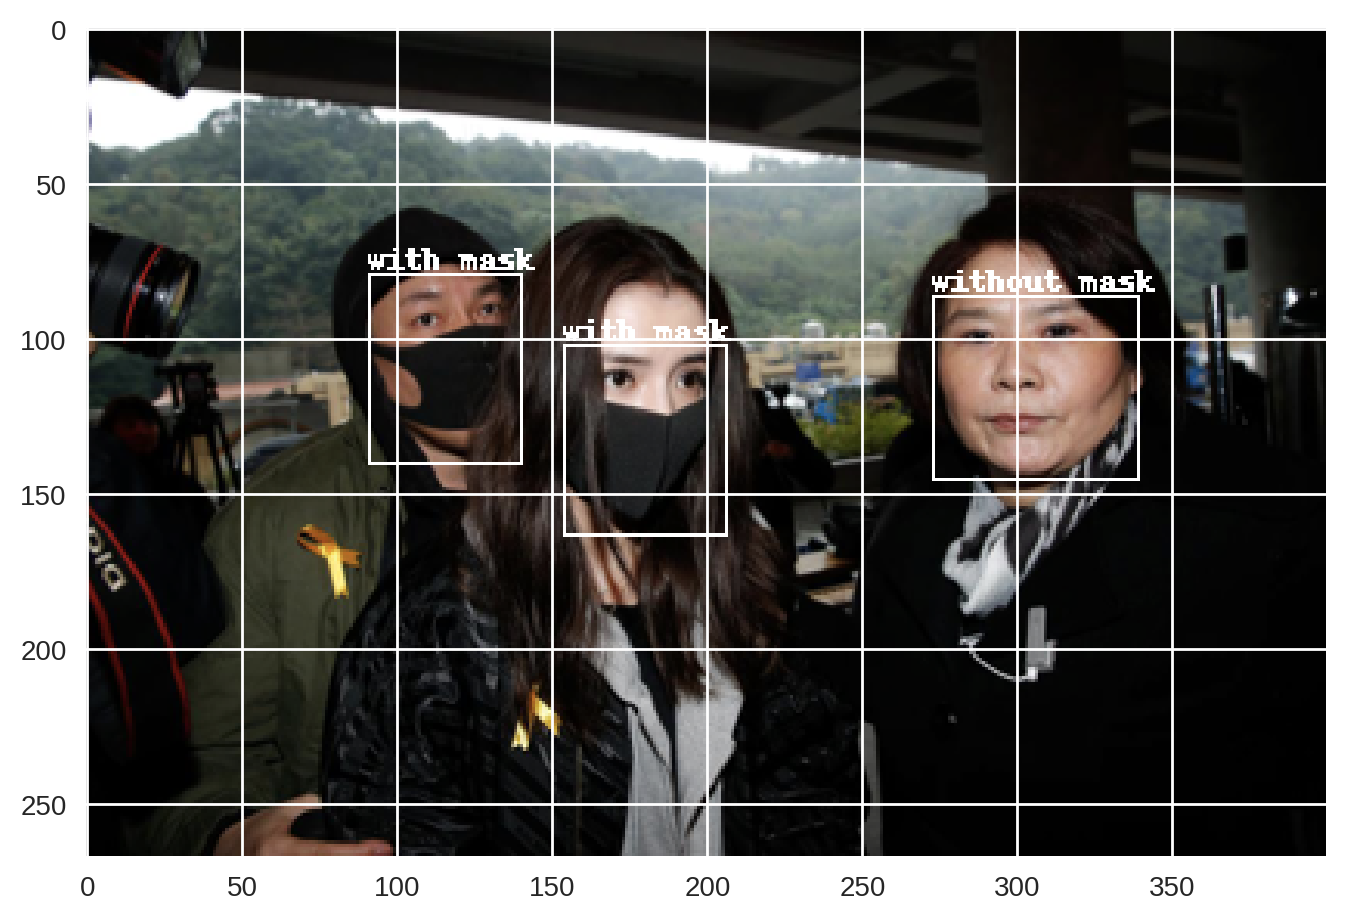

In [44]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# берем случайный файл аннотаций
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# берем связанный файл с изображением
image_file = annotation_file.replace("/content/data/annotations", "/content/data/images").replace("txt", "png")
assert os.path.exists(image_file)

# выводим изображение
image = Image.open(image_file)
plot_bounding_box(image, annotation_list)

У нас есть проблема: файлы изображений и их аннотаций находятся в одной папке. Кроме того, нужно разделить выборку на тренировочную и валидационную. А также необходимо создать (или загрузить готовый) файл .yaml нашего датасета, который пойдет в модель YOLO.

In [46]:
# считываем изображения и новый аннотации
images = [os.path.join('data/images', x) for x in os.listdir('data/images') if x[-3:] == "png"]
annotations = [os.path.join('data/annotations', x) for x in os.listdir('data/annotations') if x[-3:] == "txt"]

# сортируем
images.sort()
annotations.sort()

# сплитуем датасет
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)


In [47]:
# создаем новые папки, согласно документации YOLO
pathes = [
    "data_yolo", "data_yolo/images", "data_yolo/labels",
    "data_yolo/images/train", "data_yolo/images/val",
    "data_yolo/labels/train", "data_yolo/labels/val"
    ]
for path in pathes:
    os.mkdir(path)

In [48]:
# функция для копирования изображений в папки
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# раскидываем файлы полученных выборок по соотвествующим папкам
move_files_to_folder(train_images, 'data_yolo/images/train/')
move_files_to_folder(val_images, 'data_yolo/images/val/')
move_files_to_folder(train_annotations, 'data_yolo/labels/train/')
move_files_to_folder(val_annotations, 'data_yolo/labels/val/')

Итак, датасет для модели YOLO размещен.в папке `data_yolo`. Осталось добавить .yaml файл - его можно найти на моем GitHub в папке проекта:

In [49]:
# загружаем .yaml файл датасета
%cd '/content/data_yolo'
files.upload()
%cd ../

/content/data_yolo


Saving data_yolo.yaml to data_yolo.yaml
/content


### 4.3. Обучение модели

Попробуем испоьзовать YOLOv5 (последняя версия YOLOv8 показывает себя хуже в экспериментах):

In [61]:
# загружаем предобученную модель
model = YOLO('yolov5n.pt')

# процесс ее обучения
results = model.train(data='/content/data_yolo/data_yolo.yaml', epochs=30, imgsz=640)

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.27M/5.27M [00:00<00:00, 124MB/s]


Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=/content/data_yolo/data_yolo.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:190: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:195: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data_yolo/labels/val.cache... 169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/30      6.85G      1.721      2.793      1.376         24        640: 100%|██████████| 43/43 [00:08<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742     0.0153      0.635      0.269      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/30      7.02G      1.347        1.5      1.072         24        640: 100%|██████████| 43/43 [00:05<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.877      0.287      0.392      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/30      7.02G      1.317      1.269      1.055          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.871      0.426      0.487      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/30      7.18G      1.271      1.159      1.036         15        640: 100%|██████████| 43/43 [00:05<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.877      0.505      0.578      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/30      7.17G      1.208       1.06       1.04          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.913      0.537      0.603      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/30      7.15G      1.205      1.001      1.017          7        640: 100%|██████████| 43/43 [00:05<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.632      0.658      0.665      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/30      6.86G      1.166     0.9464      1.008          6        640: 100%|██████████| 43/43 [00:05<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.615      0.646      0.669      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/30      7.13G      1.179     0.9373      1.013          3        640: 100%|██████████| 43/43 [00:05<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.611      0.606      0.629      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/30      6.95G      1.128     0.9101          1          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.713      0.719      0.732      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/30      7.18G      1.141     0.8251     0.9911          3        640: 100%|██████████| 43/43 [00:05<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.664      0.709      0.712      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/30      7.08G       1.14     0.8144     0.9935          5        640: 100%|██████████| 43/43 [00:05<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.776      0.657      0.722      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/30      7.01G      1.142     0.8247     0.9949          1        640: 100%|██████████| 43/43 [00:05<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.704      0.704      0.729      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/30      7.02G      1.109     0.7543     0.9801          2        640: 100%|██████████| 43/43 [00:06<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.732      0.741      0.752      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/30      7.01G      1.098     0.7793     0.9955          1        640: 100%|██████████| 43/43 [00:05<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.806      0.735       0.79      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/30      6.86G      1.102     0.7415     0.9834         12        640: 100%|██████████| 43/43 [00:05<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.741      0.702      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/30      6.86G      1.105     0.7426     0.9803         16        640: 100%|██████████| 43/43 [00:06<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.754      0.756      0.765       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/30      6.85G      1.092     0.7137     0.9753          8        640: 100%|██████████| 43/43 [00:05<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.742      0.728      0.741      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/30      6.98G      1.088     0.6901     0.9841          3        640: 100%|██████████| 43/43 [00:05<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.796      0.743      0.801      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/30      6.99G      1.048     0.6651     0.9602         11        640: 100%|██████████| 43/43 [00:05<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.793      0.783      0.814      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/30      6.99G      1.059     0.6596      0.956         10        640: 100%|██████████| 43/43 [00:05<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742       0.89      0.727      0.816      0.544


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/30      6.96G      1.054     0.6405     0.9634          1        640: 100%|██████████| 43/43 [00:08<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.777      0.798      0.815      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/30      6.97G      1.032     0.6352     0.9484          1        640: 100%|██████████| 43/43 [00:05<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.812      0.751      0.815      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/30      7.15G      1.019     0.6368     0.9465          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.794      0.798      0.822      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/30      7.02G      1.021     0.6086     0.9418         18        640: 100%|██████████| 43/43 [00:05<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.842      0.761      0.831       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/30      7.02G      1.005      0.589     0.9385          6        640: 100%|██████████| 43/43 [00:05<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.822      0.722      0.813      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/30      7.16G      1.006     0.5811     0.9421          6        640: 100%|██████████| 43/43 [00:05<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.788      0.797      0.816      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/30      6.99G     0.9809     0.5659     0.9332          6        640: 100%|██████████| 43/43 [00:05<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.811      0.811       0.83      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/30      7.04G      0.976     0.5635     0.9422          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.807      0.796      0.838      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/30      7.03G     0.9674     0.5533      0.929          2        640: 100%|██████████| 43/43 [00:05<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742       0.85      0.788      0.861      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/43 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:191: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/30      7.04G     0.9693     0.5495     0.9474          3        640: 100%|██████████| 43/43 [00:05<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R    

                   all        169        742      0.843      0.816      0.857      0.585



30 epochs completed in 0.085 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.3MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv5n summary (fused): 193 layers, 2503529 parameters, 0 gradients, 7.1 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:190: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:156.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:195: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

                   all        169        742       0.85      0.788      0.861      0.585
 mask_weared_incorrect        169         32      0.774      0.641      0.767      0.522
             with_mask        169        608      0.934       0.91      0.951      0.665
          without_mask        169        102      0.841      0.814      0.865      0.569
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 11.1ms postprocess per image
Results saved to runs/detect/train4


Полученные метрики:

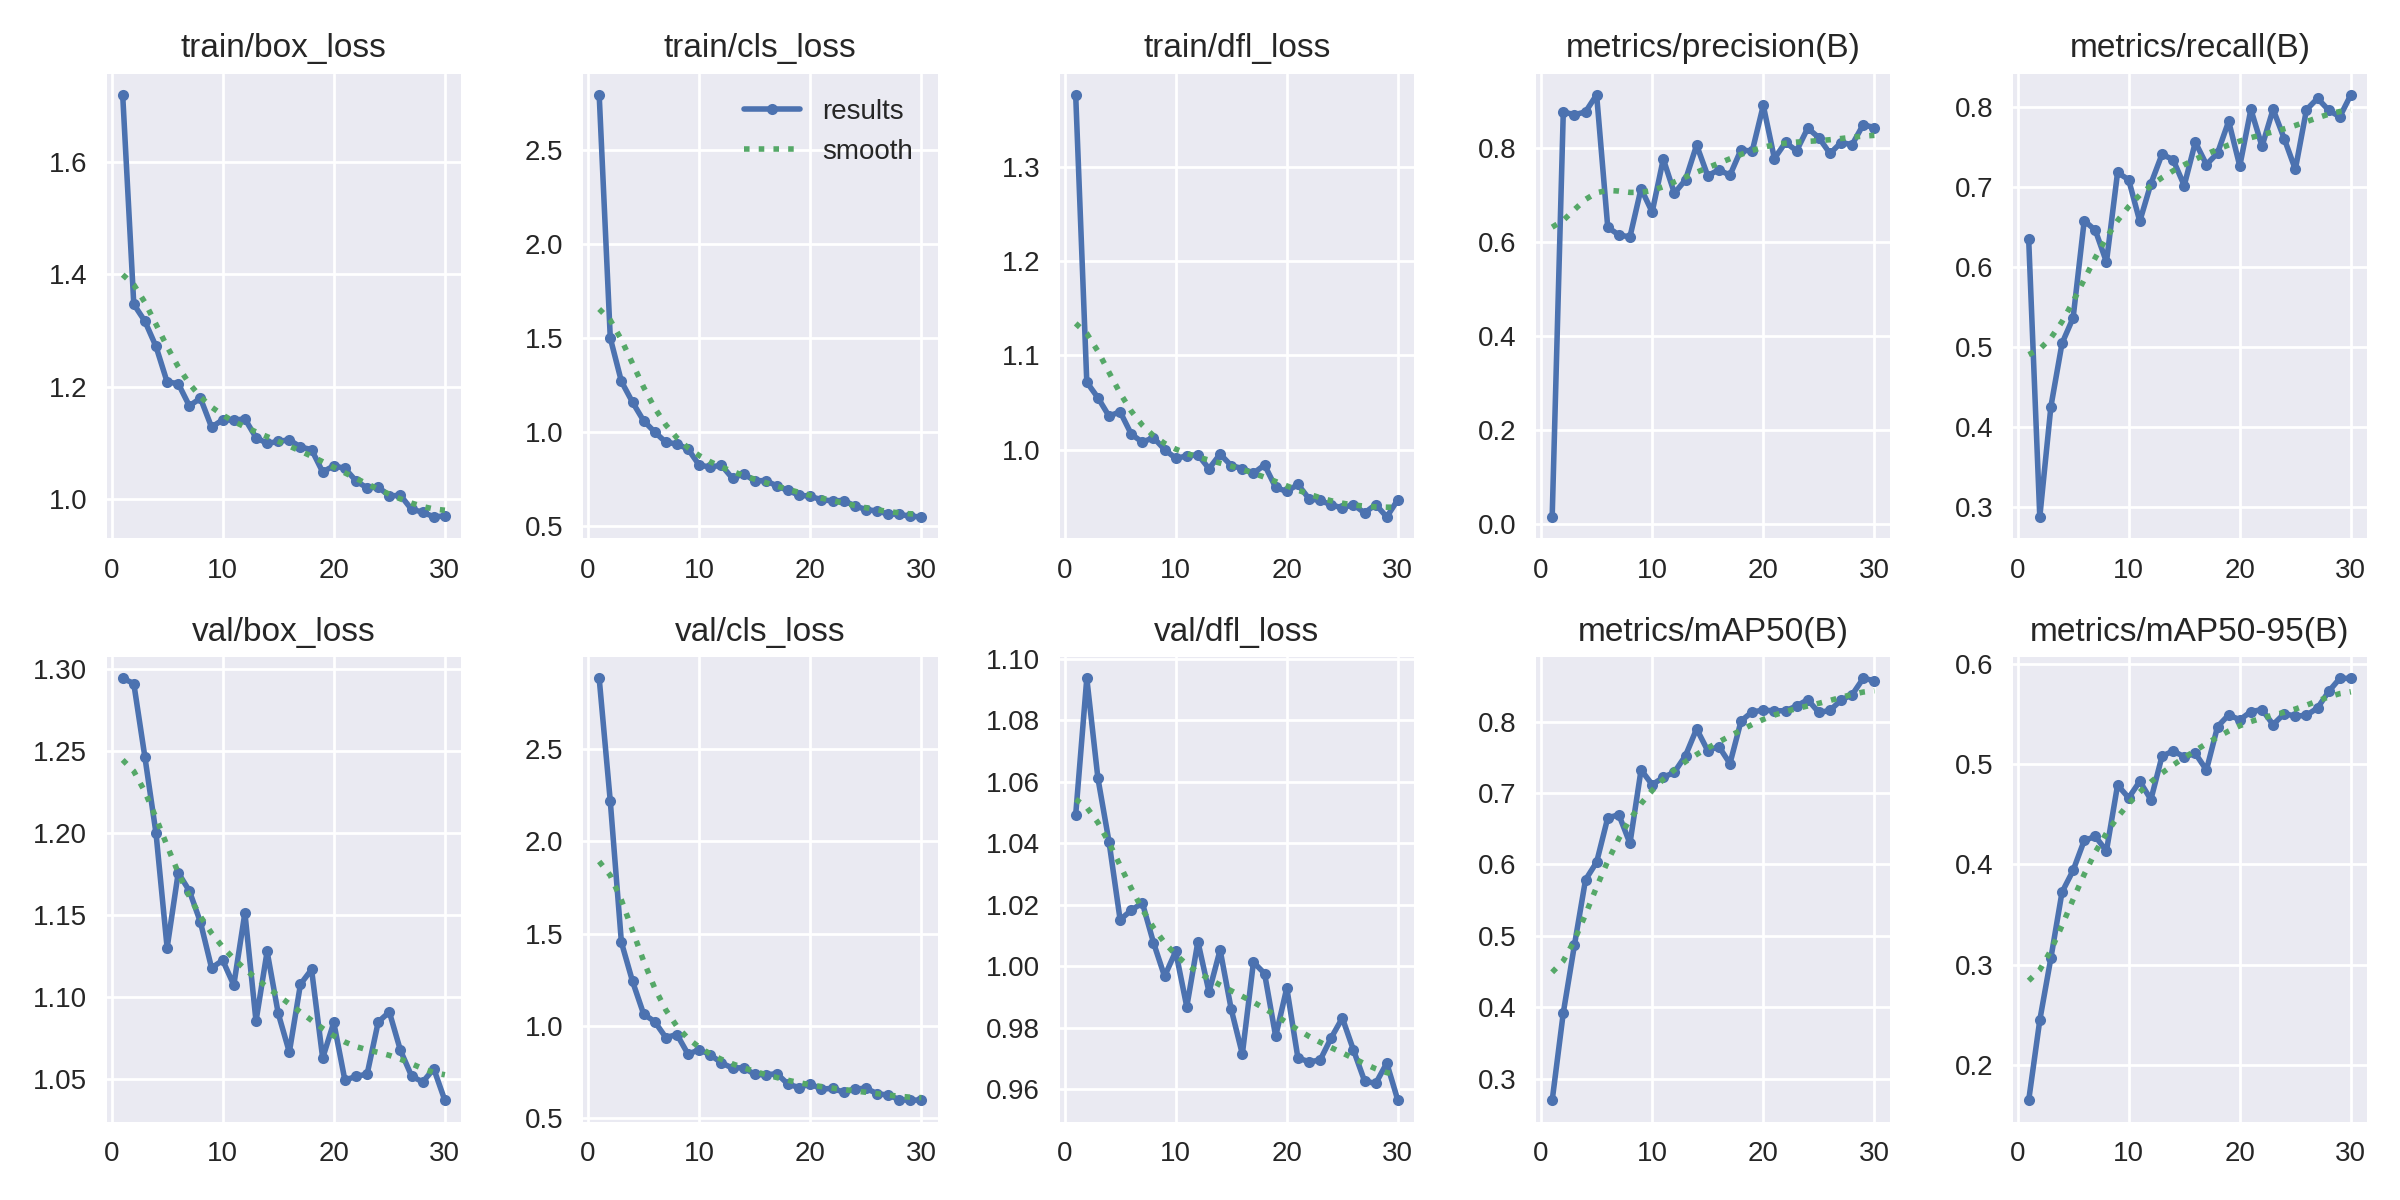

In [62]:
Image('/content/runs/detect/train4/results.png', width=1000)

Мы достигли значения целевой метрики mAP_50 > 0.85 !

### 4.4. Визуализация полученных результатов

- Отрисуем батч на валидации:

TARGET


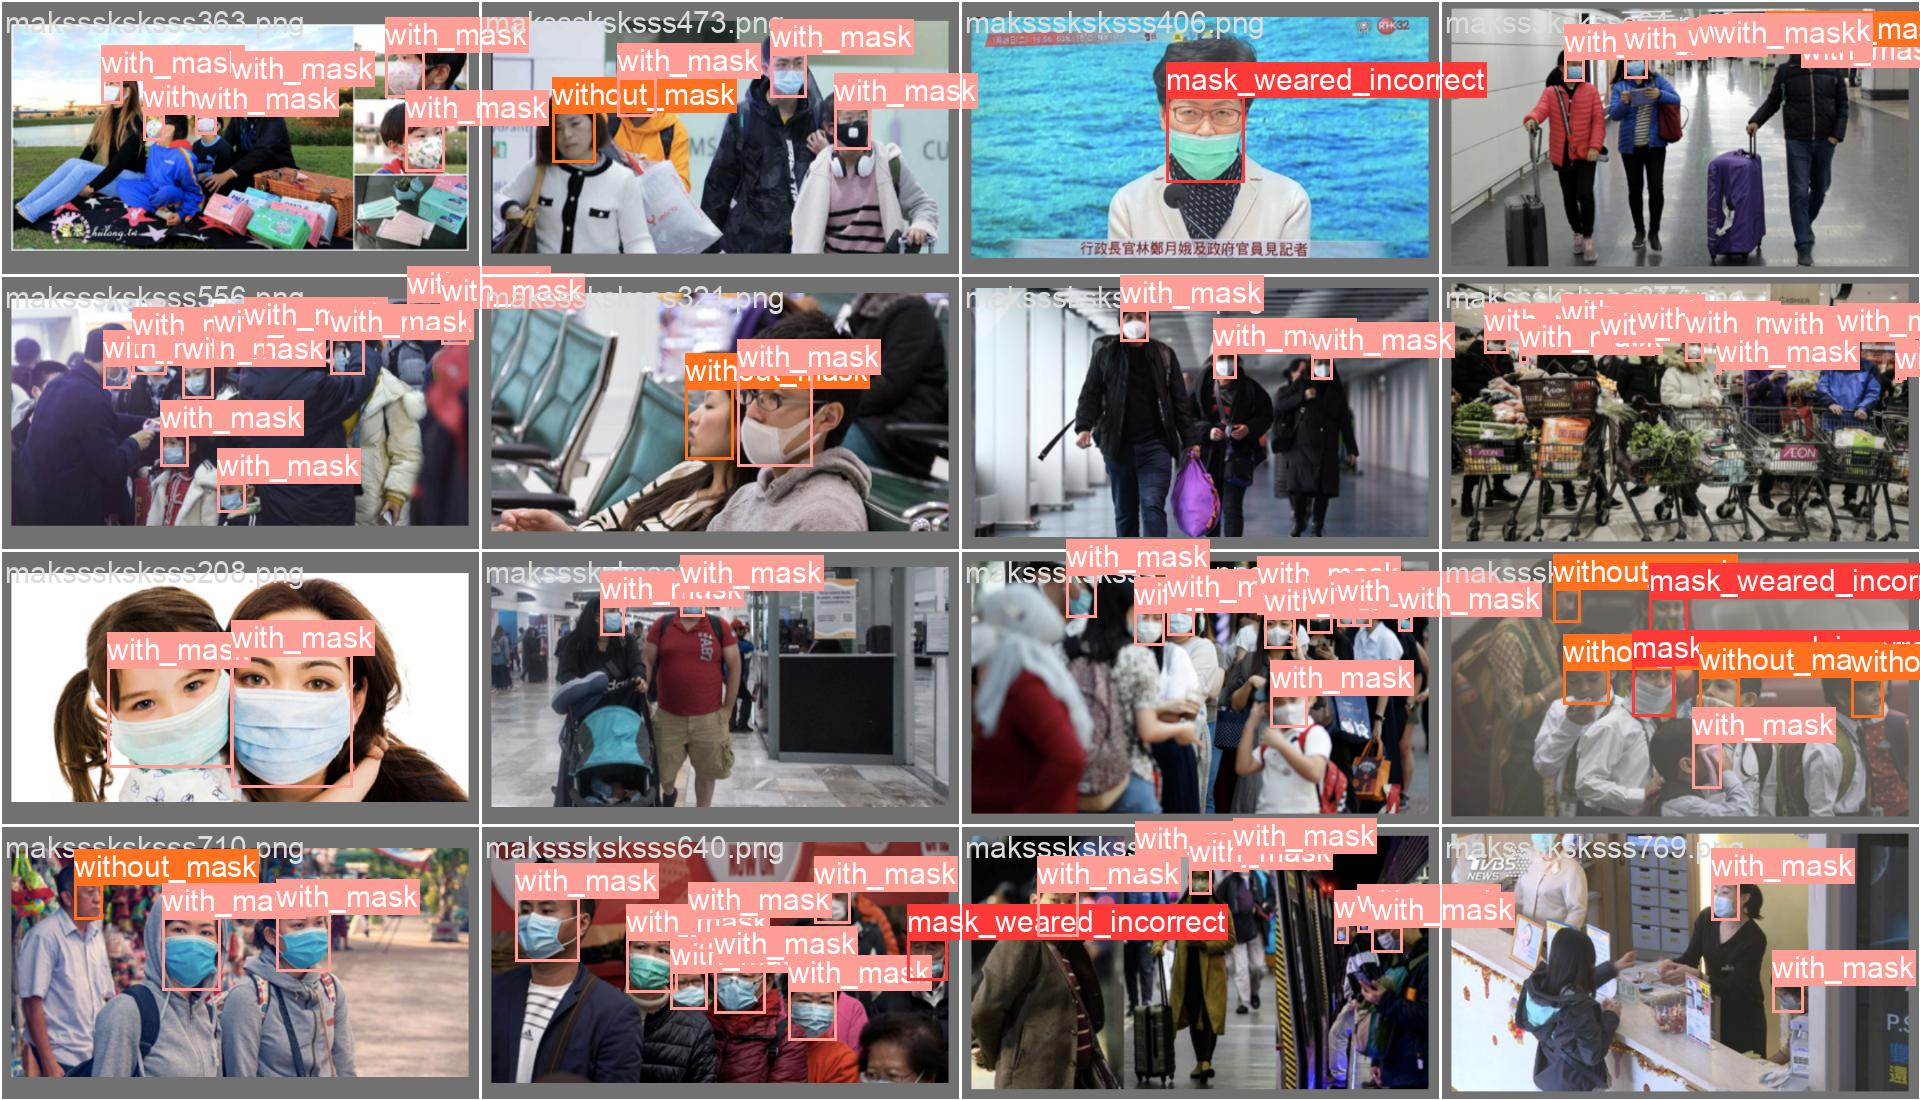

In [63]:
print("TARGET")
Image('/content/runs/detect/train4/val_batch0_labels.jpg', width=1000)

PREDICTION


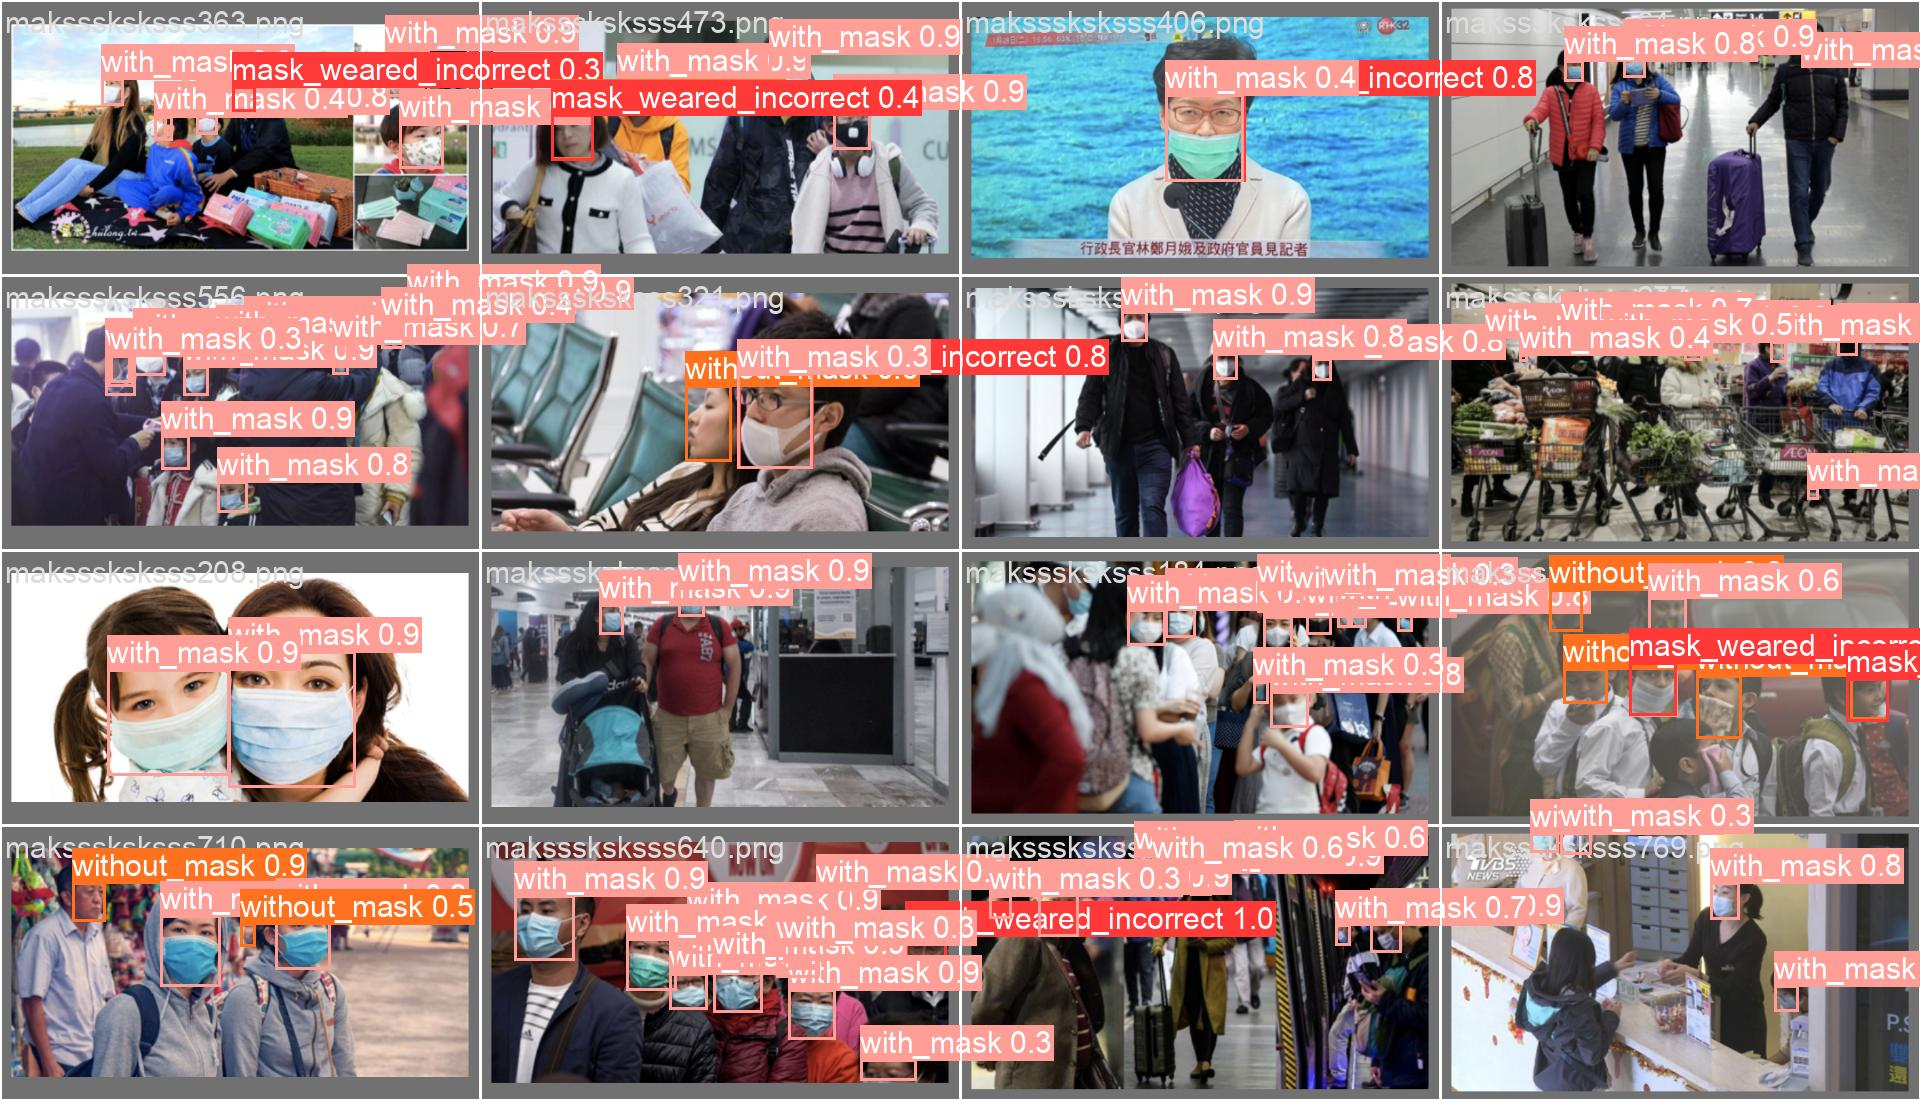

In [64]:
print("PREDICTION")
Image('/content/runs/detect/train4/val_batch0_pred.jpg', width=1000)

- Инференс:

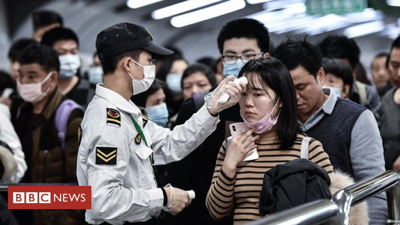

In [81]:
Image('/content/data_yolo/images/val/maksssksksss176.png', width=1000)

In [82]:
results = model(['/content/data_yolo/images/val/maksssksksss176.png'])


0: 384x640 1 mask_weared_incorrect, 9 with_masks, 6 without_masks, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


In [83]:
# обрабаываем инференс
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk

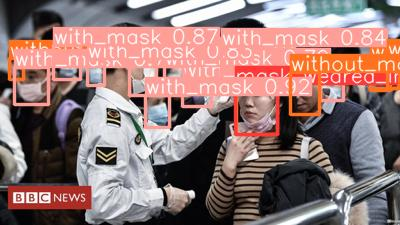

In [85]:
Image('/content/result.jpg', width=1000)

In [86]:
# сохраним зависимости

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip freeze > requirements.txt

## 5. Выводы
- проект выполнен на платформе Google Colab Pro, датасет был загружен с Kaggle
- обнаружены проблемы с некоторыми файлами изображений датасета, которые приводили к багам в модуле Albumentations (на Kaggle старые версии библиотек и там все работает нормально)
- проблемные файлы удалены из выборки
- обучены 2 детектора, относящиеся с моделям типа Faster RCNN и YOLO
- целевую метрику mAP удалось достичь при обучении обоих детекторов
- YOLO более проста для новичка, менее русурсозатратна, однако на данном проекте выявились следующие ее недостатки:
  - свой собственный формат данных, что усложняет подготовку датасета и при неправильной конвертации резко снижает качество обучения
  - целевой метрики удалось достичь только на 30 эпохах (faster RCNN справилась за 20)
